# 1. **Develop solution:**  Semantic Image segmentation for fashion industry

This demo focuses on the task of **semantic image segmentation** for **fashion industry**.

***What is semantic image segmentation?***

**Semantic Segmentation** is a classic Computer Vision problem which involves taking as input some raw data (eg., 2D images) and converting them into a mask with regions of interest highlighted. Many use the term full-pixel semantic segmentation, where each pixel in an image is assigned a classID depending on which object of interest it belongs to. Semantic image segmentation is the process of mapping and classifying the natural world for many critical applications such as especially **autonomous driving, robotic navigation, localization, Precision Agriculture, GeoSensing – For land usage, Facial Segmentation, Categorizing clothing items, healthcare and scene understanding**.

This workshop uses the Clothing Co-Parsing (CCP) dataset is a new clothing database including elaborately annotated clothing items.(https://github.com/amirgholipour/clothing-co-parsing)

The dataset consists of

    + 2, 098 high-resolution street fashion photos with totally 59 tags
    + Wide range of styles, accessaries, garments, and pose
    + All images are with image-level annotations
    + 1000+ images are with pixel-level annotations

## 1.1. Introduction

In this notebook, we'll learn how to **do semantic Image segmentation for fashion industry**, using a modified <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

This will allow you to discover, step by step, how you can create the code doing the recognition. In the last part of the workshop, this exact same code will be **packaged to create a service** that you can query from any application!

We will use a **pre-trained model** as it takes a **long time** and **lots of data** to train such a model. However, you'll find the code to train the model as a reference in this repository if you're interested to learn more.

Ready? Let's go!

## 1.2.  Install the modeling requirements and libraries

First, we'll need to **install some libraries** that are not part of our container image. Normally, **Red Hat OpenShift Data Science** is already taking care of this for you, based on what it detects in the code. **Red Hat OpenShift Data Science** will reinstall all those libraries for you every time you launch the notebook!

In case you're using this notebook in a different environment, or just to make sure everything is ready, you can run the following cell to install OpenCV (a library to work with images) and Keras (an abstraction layer over Tensorflow).

In [ ]:
%pip install git+https://github.com/tensorflow/examples.git
%pip install -r requirements.txt
%pip install tensorflow --upgrade

## 1.3.  Importing the needed libraries and packages
Of course, we'll need to import various packages. They are either built in the notebook image you are running, or have been installed in the previous step.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np
import matplotlib.pyplot as plt
from git import Repo
import time
import shutil
import sys
from src.dataloading.read_dataset import readData
from src.features.data_preprocessing import preprocessData
from src.visualization.visualize import visualizeData, DisplayCallback
from src.modules.build_model import buildModel
from src.modules.train_model import  trainModel
from src.modules.predict_model import predictor
from src.hyper_parameters.hps import get_hyper_paras
from src.github.git_utils import gitCommands

## 1.4. Initialize some hyper-parameters

In [2]:
BATCH,STEPS_PER_EPOCH,VALIDATION_STEPS,EPOCHS,VAL_SUBSPLITS = get_hyper_paras()

## 1.5. Reading the Clothing Co-Parsing (CCP) Dataset

The dataset is Clothing Co-Parsing (CCP) Dataset (https://github.com/amirgholipour/clothing-co-parsing.git). The semantic segmentation masks are included.

In [3]:
images,masks = readData().readImageData()

(1000, 1000)


## 1.6.  Data Preprocessing

We need to resize the data to make them ready for feeing to our model

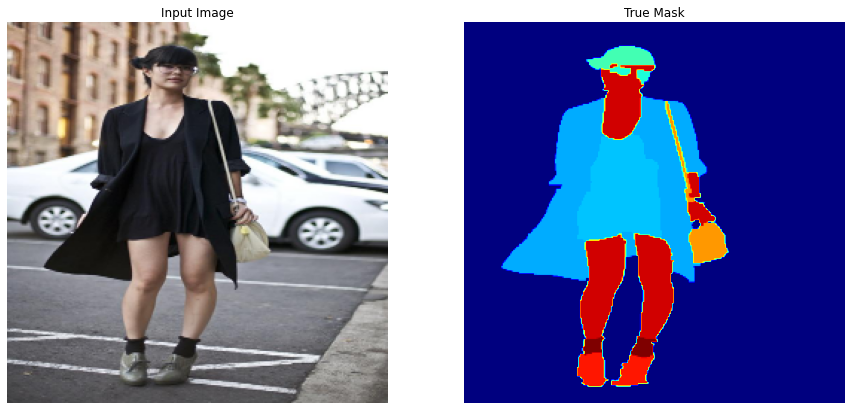

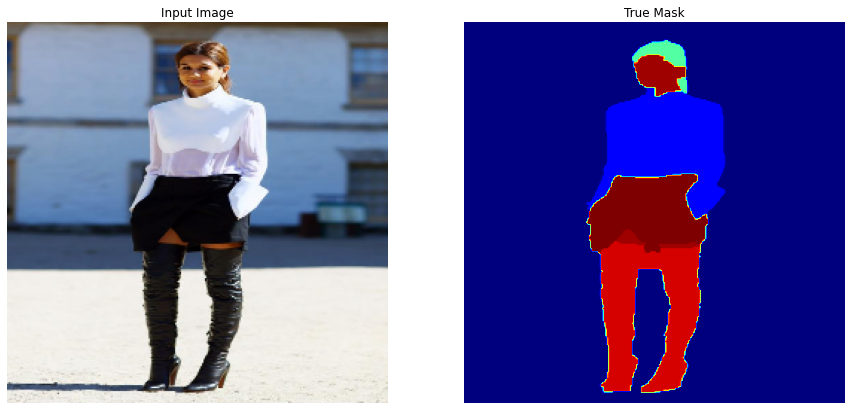

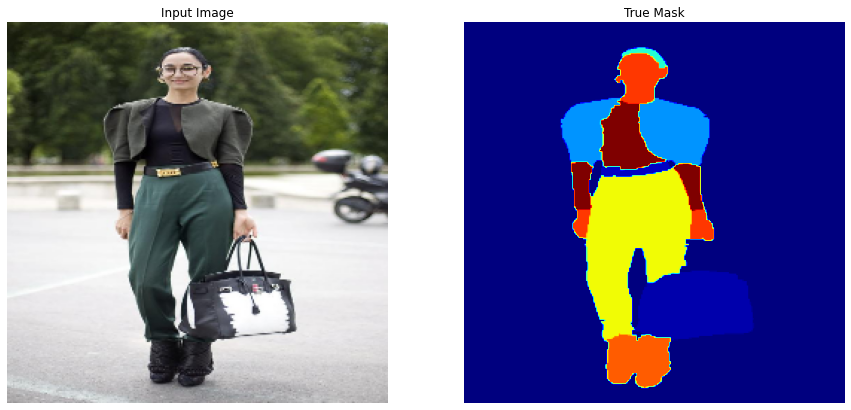

1000 1000
TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None) TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None) TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None) TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None)


In [4]:
train,val,sample_image, sample_mask = preprocessData(images,masks).dataPreProcessing()

## 1.7.  Design and compile the model 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 128, 128, 1  5667664     ['input_2[0][0]']                
                                6),                                                               
                                 (None, 64, 64, 128                                               
                                ),                                                                
                                 (None, 32, 32, 192                                         

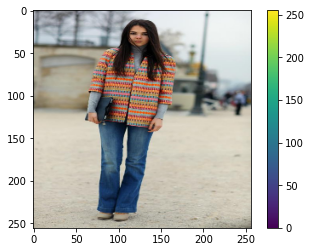

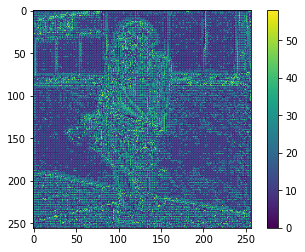

In [5]:
model = buildModel(train_data = train).setupModel()

## 1.8.  Training the Model

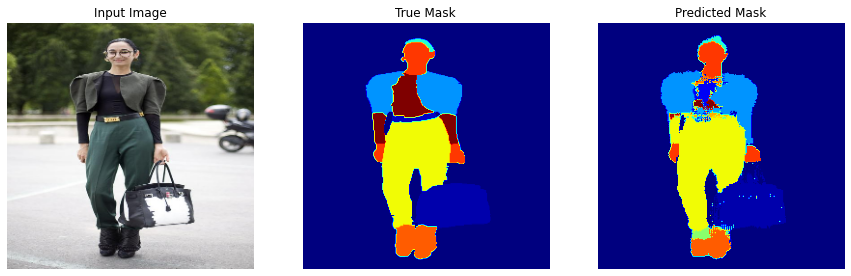


Sample Prediction after epoch 63

12/12 [==============================] - 52s 4s/step - loss: 0.5716 - accuracy: 0.8512 - val_loss: 0.5183 - val_accuracy: 0.8674


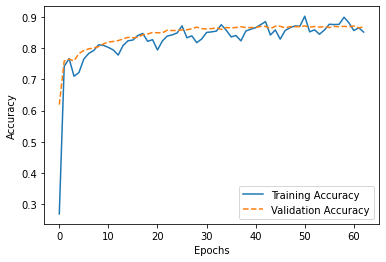

In [6]:
model = trainModel(model,train_data=train, test_data=val,validation_steps =VALIDATION_STEPS, step_per_epoch = STEPS_PER_EPOCH ,ckpp ='./models/SemImSeg_model_EfficientNetV2B0.h5',  val_subsplits = VAL_SUBSPLITS, batch_size=BATCH,epochs=EPOCHS,sample_image = sample_image ,sample_mask=sample_mask,display_callback =DisplayCallback).modelTraining()

## 1.9.  Test Model based on validation data

Loading model 2956
Loaded model
####


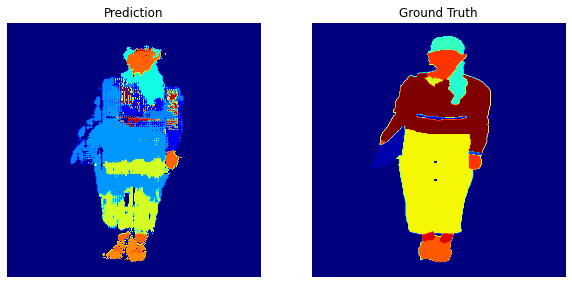

In [7]:
predictor(val_data=val, model_path='/models/SemImSeg_model_EfficientNetV2B0.h5').predict()

## 1.10.  Clean dataset folder

In [8]:
os.system('rm -rf clone')

0

## 1.11. Update the private git repo

In [9]:
base, repoName = os.path.split(os.getcwd())
temp=time.localtime(time.time())
uploaddate= 'Update with the latest change ' + str(temp[0])+'_'+str(temp[1])+'_'+str(temp[2])+'_'+str(temp[3])+'_'+str(temp[4])
gitCommands(repo_dir = os.getcwd(),repo_name = repoName,git_email= os.environ['GIT_EMAIL'], git_username = os.environ['GIT_USER_NAME'].lower(), git_token = os.environ['GIT_TOKEN'], commit_message = uploaddate, file_name = '.').gitPush()

b'' b''
b'[main 1b7bdfc] Update with the latest change 2022_3_28_3_26\n 64 files changed, 1520 insertions(+), 1657 deletions(-)\n create mode 100644 .ipynb_checkpoints/01_sandbox-checkpoint.ipynb\n create mode 100644 .ipynb_checkpoints/02_Semantic_Image_Segmentation-checkpoint.ipynb\n delete mode 100644 .ipynb_checkpoints/02_Semantic_Image_Segmentation_Simpler-checkpoint.ipynb\n rename .ipynb_checkpoints/{03_SemISeg_run_application-checkpoint.ipynb => 03_SIS_run_application-checkpoint.ipynb} (100%)\n rename .ipynb_checkpoints/{04_SemISeg_test_application-checkpoint.ipynb => 04_SIS_test_application-checkpoint.ipynb} (100%)\n create mode 100644 02_Semantic_Image_Segmentation.ipynb\n delete mode 100644 02_Semantic_Image_Segmentation_Simpler.ipynb\n rename 03_SemISeg_run_application.ipynb => 03_SIS_run_application.ipynb (100%)\n rename 04_SemISeg_test_application.ipynb => 04_SIS_test_application.ipynb (100%)\n rename test_sample_28.jpg => dataset/.ipynb_checkpoints/test_sample_28-checkpoin

__Thank you for your time!__

# 2. Deploy solution for Semantic Image segmentation

## 2.1 Move the prediction file to the inference repo

In [10]:

repoName = 'SIS-Inference'
repoDir= base +'/'+repoName
model_name = '/models/SemImSeg_model_EfficientNetV2B0.h5'
shutil.move(os.getcwd()+model_name, base+'/'+repoName+model_name)

'/opt/app-root/src/SIS-Inference/models/SemImSeg_model_EfficientNetV2B0.h5'

## 2.2 Push the change to the inference repo 

In [11]:
gitCommands(repo_dir = repoDir,repo_name = repoName,git_email= email, git_username = username, git_token = token, commit_message = uploaddate, file_name = '.').gitPush()

NameError: name 'email' is not defined

Now Just need to go to **Redhat Openshift Dedicated** to deploy the app :)